In [6]:
%pip install tensorflow
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install jupyter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 35.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 43.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 35.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66/66 [jupyter]4/66 [notebook]b]server]s]
Note: you may need to restart the kernel to use updated packages.


In [11]:
# 対応表のパスを設定
csv_path = 'c:\\Users\\souta\\Documents\\Test\\testB\\data\\train.csv'
data_dir = 'c:\\Users\\souta\\Documents\\Test\\testB\\data\\train\\train'

# 対応表を読み込み
df = pd.read_csv(csv_path)

df_filtered = df[df['gender_status'] != 5]

In [8]:
# 各カテゴリの画像の枚数を数える
category_counts = df['gender_status'].value_counts()

# 結果を表示
for category, count in category_counts.items():
    print(f"カテゴリ {category} の画像枚数: {count}")

カテゴリ 1 の画像枚数: 1294
カテゴリ 0 の画像枚数: 1210
カテゴリ 4 の画像枚数: 834
カテゴリ 2 の画像枚数: 375
カテゴリ 3 の画像枚数: 371
カテゴリ 7 の画像枚数: 100
カテゴリ 6 の画像枚数: 53
カテゴリ 5 の画像枚数: 1


c:\Users\souta\anaconda3\envs\testB\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\souta\anaconda3\envs\testB\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\souta\anaconda3\envs\testB\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12468 (\N{KATAKANA LETTER GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\souta\anaconda3\envs\testB\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\souta\anaconda3\envs\testB\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from fon

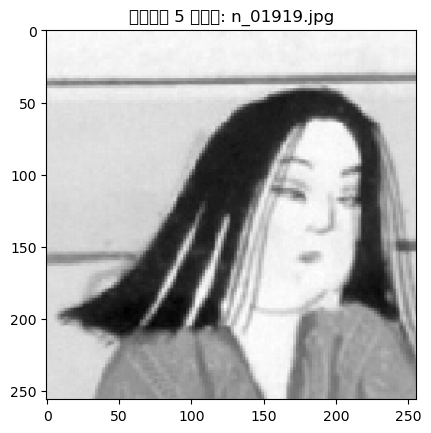

In [15]:
# カテゴリ5の画像のパスを取得
category_5_images = df[df['gender_status'] == 5]['image'].tolist()

# 画像の表示
for img_name in category_5_images:
    img_path = os.path.join(data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        plt.imshow(img, cmap='gray')
        plt.title(f"カテゴリ 5 の画像: {img_name}")
        plt.show()
    else:
        print(f"画像が見つからないか、読み込めませんでした: {img_path}")

In [13]:
# データとラベルを格納するリスト
x_data = []
y_data = []

# データの読み込み
for index, row in df_filtered.iterrows():
    img_path = os.path.join(data_dir, row['image'])  # 'image' 列を使用
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (100, 100))
        x_data.append(img)
        y_data.append(row['gender_status'])  # 'gender_status' 列を使用
    else:
        print(f"画像が見つからないか、読み込めませんでした: {img_path}")

# NumPy配列に変換
x_data = np.array(x_data).reshape(-1, 100, 100, 1)
y_data = np.array(y_data)

# クラス重みを計算
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_data), y=y_data)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# データをトレーニングセットと検証セットに分割
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3, random_state=42, stratify=y_data)

# データのシャッフル
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_val, y_val = shuffle(x_val, y_val, random_state=42)

# ラベルをカテゴリカルデータに変換
y_train_categorical = to_categorical(y_train, num_classes=8)
y_val_categorical = to_categorical(y_val, num_classes=8)

In [ ]:
# モデルの定義
inputs = Input(shape=(100, 100, 1))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

#x = Flatten()(x)
#x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x) #グローバルアヴェレージツーリングに変更
x = Dropout(0.5)(x)
outputs = Dense(8, activation='softmax')(x)

history_model = Model(inputs=inputs, outputs=outputs)

# モデルのコンパイル
history_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# 早期終了のコールバックを設定
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [17]:
# モデルの訓練
history = history_model.fit(x_train, y_train_categorical
                                     , epochs=50, batch_size=64
                                     , validation_data=(x_val, y_val_categorical)
                                     , class_weight=class_weights_dict, callbacks=[early_stopping]
                                     , shuffle=True
                                     )

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 511ms/step - accuracy: 0.2226 - loss: 2.0980 - val_accuracy: 0.0487 - val_loss: 3.8861
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 506ms/step - accuracy: 0.4038 - loss: 1.4465 - val_accuracy: 0.1934 - val_loss: 2.3779
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - accuracy: 0.4476 - loss: 1.3275 - val_accuracy: 0.3616 - val_loss: 1.7255
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 517ms/step - accuracy: 0.4780 - loss: 1.2647 - val_accuracy: 0.4167 - val_loss: 1.6508
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 499ms/step - accuracy: 0.5092 - loss: 1.2075 - val_accuracy: 0.3821 - val_loss: 1.7775
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 502ms/step - accuracy: 0.5102 - loss: 1.1386 - val_accuracy: 0.3483 - val_loss: 1.8741
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 504ms/step - accuracy: 0.5526 - loss: 1.0429 - val_accuracy: 0.3357 - val_loss: 2.0914
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 510ms/step - accuracy: 0.5823 - loss: 0.9312 - val_accu

In [ ]:
# テストデータのディレクトリパスを設定
test_data_dir = 'c:\\Users\\souta\\Documents\\Test\\testB\\data\\test\\test'

# テストデータの画像を読み込み、前処理
x_test = []
image_names = []

for img_name in os.listdir(test_data_dir):
    img_path = os.path.join(test_data_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (100, 100))
        x_test.append(img)
        image_names.append(img_name)
    else:
        print(f"画像が見つからないか、読み込めませんでした: {img_path}")

# NumPy配列に変換
x_test = np.array(x_test).reshape(-1, 100, 100, 1)

# 予測を行う
predictions = history_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# 結果をDataFrameにまとめる
results_df = pd.DataFrame({'image': image_names, 'predicted_gender_status': predicted_classes})

# 結果をCSVファイルに保存
results_csv_path = 'c:\\Users\\souta\\Documents\\Test\\testB\\data\\predictions.csv'
results_df.to_csv(results_csv_path, index=False)

print(f"予測結果が {results_csv_path} に保存されました。")

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
予測結果が c:\Users\souta\Documents\Test\testB\data\predictions.csv に保存されました。
